In [6]:
from mpi4py import MPI
from petsc4py import PETSc

from tqdm.notebook import tqdm_notebook

import numpy as np

import ufl

from dolfinx import fem, io, mesh, plot, la
from dolfinx.fem.petsc import assemble_matrix, create_vector, apply_lifting, NonlinearProblem, LinearProblem
from dolfinx.nls.petsc import NewtonSolver
from basix.ufl import element, mixed_element
from dolfinx.io import XDMFFile

import pyvista

https://www.wias-berlin.de/people/john/BETREUUNG/master_ding.pdf
https://www.youtube.com/watch?v=LflB3-bEK2M
http://redbkit.github.io/redbKIT/math/AdvDiffReact/#id

In [7]:
# create mesh for calculations to take place in
msh = mesh.create_unit_square(MPI.COMM_WORLD, 16,16)

# define elements to be used for the velocity and the distribution
z_p1 = element("P", msh.basix_cell(), 1)
v_p2 = element("P", msh.basix_cell(), 2, shape=(msh.geometry.dim,))

# define mixed element and function space to be used when there are multiple compounds.
ME = mixed_element([z_p1, z_p1, z_p1])
ZMixed = fem.FunctionSpace(msh, ME)

# Define function spaces to be used for the two variables
# Z = fem.FunctionSpace(msh, z_p1)
V = fem.FunctionSpace(msh, v_p2)

In [8]:
# define functions to be used for boundaries and initials
def initial_condition(x, a=5):
    return np.exp(-a * (x[0]**2 + x[1]**2))

def initial_condition_2(x, a=5):
    return np.exp(-a * (x[0]**2 + (x[1]-1)**2))

def inital_ones(x):
    return np.ones((1, x.shape[1]))

def flow(x):
    return np.stack((np.ones(x.shape[1]), np.zeros(x.shape[1])))
    
# Function to mark the lid (y = 1)
def lid(x):
    return np.isclose(x[1], 1)

def inflow_point(x):
    return np.isclose(x[0], 0) & np.isclose(x[1], 0.5)

# define time step variables 
T = 1.3          # final time
num_steps = 1300  # number of time steps
dt = T / num_steps # time step size
# dt= 0.1

In [9]:
# # define boundary conditions
# inflow_dofs = fem.locate_dofs_geometrical(Z, lid)
# bc_inflow = fem.dirichletbc(PETSc.ScalarType(1), inflow_dofs, Z)
# bc_outlfow = fem.dirichletbc(PETSc.ScalarType(-1), inflow_dofs, Z)

# # order here is important as want to apply outflow before the inflow
# bcs = [bc_outlfow, bc_inflow]
bcs = []

In [10]:
# Create variables for results at current and previous timesteps
s_ = fem.Function(ZMixed)
# s_.interpolate(initial_condition)
s_n = fem.Function(ZMixed)
# s_n.interpolate(initial_condition)

s1_, s2_, s3_ = ufl.split(s_)
s1_n, s2_n, s3_n = ufl.split(s_n)

# s1_.name = "s1"
# s2_.name = "s2"
# s3_.name = "s3"

s_.sub(0).interpolate(initial_condition)
s_n.sub(0).interpolate(initial_condition)
s_.sub(1).interpolate(initial_condition_2)
s_n.sub(1).interpolate(initial_condition_2)

# s_.x.array[:] = 1
# s_n.x.array[:] = 1
# s2_.x.array[:] = 1
# s2_n.x.array[:] = 1

# s3_.x.array[:] = 0
# s3_n.x.array[:] = 0

# very basic flow variable
u_n = fem.Function(V)
u_n.interpolate(flow)

# create trial and test functions
# s1, s2, s3 = ufl.TrialFunctions(ZMixed)
z1, z2, z3 = ufl.TestFunctions(ZMixed)

In [11]:
# https://github.com/unifem/fenics-notes/blob/master/notebooks/advection-diffusion-reaction.ipynb
# https://jsdokken.com/dolfinx-tutorial/chapter2/diffusion_code.html

# constants for calculations
rho = fem.Constant(msh, PETSc.ScalarType(10)) # advection coefficent
eps = fem.Constant(msh, PETSc.ScalarType(1)) # diffusion coefficent
k = fem.Constant(msh, dt)
fs = fem.Constant(msh, PETSc.ScalarType(0))
K = fem.Constant(msh, PETSc.ScalarType(10))

# https://fenicsproject.discourse.group/t/navier-stokes-and-convection-diffusion/7170
F = ((s1_ - s1_n) / k) *z1*ufl.dx # advective terms
F += rho*ufl.dot(u_n, ufl.grad(s1_))*z1*ufl.dx # advective terms
F += eps * ufl.dot(ufl.grad(s1_), ufl.grad(z1))* ufl.dx # diffusive term
F += K * s1_ * s2_ * z1 * ufl.dx # reactive term
F -=  fs*z1*ufl.dx
F += ((s2_ - s2_n) / k) *z2*ufl.dx # advective terms
F += rho*ufl.dot(u_n, ufl.grad(s2_))*z2*ufl.dx # advective terms
F += eps * ufl.dot(ufl.grad(s2_), ufl.grad(z2))* ufl.dx # diffusive term
F += K * s1_ * s2_ * z2 * ufl.dx # reactive term
F -=  fs*z2*ufl.dx
F += ((s3_- s3_n) / k) *z3*ufl.dx # advective terms
F += rho*ufl.dot(u_n, ufl.grad(s3_))*z3*ufl.dx # advective terms
F += eps * ufl.dot(ufl.grad(s3_), ufl.grad(z3))* ufl.dx # diffusive term
F += - K * s1_ * s2_ * z3 * ufl.dx #+ K * s3_ * z3 * ufl.dx
F -=  fs*z3*ufl.dx

# a = fem.form(ufl.lhs(F))
# L = fem.form(ufl.rhs(F))

# Just diffusion equation
# https://jsdokken.com/dolfinx-tutorial/chapte400r2/diffusion_code.html
# a = fem.form(s * z * ufl.dx + dt * ufl.dot(ufl.grad(s), ufl.grad(z)) * ufl.dx)
# L = fem.form((s_n + dt * fs) * z * ufl.dx)

# create parts of the equation that will not change between timesteps
# https://fenicsproject.discourse.group/t/how-to-set-bcs-for-petsc-matrices-and-petsc-vectors-in-dolfinx/4135
# A = assemble_matrix(a, bcs=bcs)
# A.assemble()
# b = create_vector(L)

# # create solver for the linear (matrix) problem
# ## Using petsc4py to create a linear solver
# # As we have already assembled `a` into tbhe matrix `A`, we can no longer use the `dolfinx.fem.petsc.LinearProblem` class to solve the problem. Therefore, we create a linear algebra solver using PETSc, and assign the matrix `A` to the solver, and choose the solution strategy.
# solver2 = PETSc.KSP().create(msh.comm)
# solver2.setOperators(A)
# solver2.setType(PETSc.KSP.Type.PREONLY)
# solver2.getPC().setType(PETSc.PC.Type.LU)

prob = NonlinearProblem(F, s_)
solver = NewtonSolver(MPI.COMM_WORLD, prob)


In [12]:
# solver.convergence_criterion = "residual"
# solver.rtol = 1e-2
# solver.report = True

ksp = solver.krylov_solver
# opts = PETSc.Options()
# option_prefix = ksp.getOptionsPrefix()
# opts[f"{option_prefix}ksp_type"] = "cg"
# # opts[f"{option_prefix}pc_type"] = "gamg"
# opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
# ksp.setFromOptions()
# ksp.setInitialGuessNonzero(True)

In [13]:
# https://jsdokken.com/dolfinx-tutorial/chapter2/diffusion_code.html
# create output file44

output = io.XDMFFile(msh.comm, "results/mixed/combined.xdmf", "w")
output.write_mesh(msh)

# xdmf0 = io.XDMFFile(msh.comm, "results/mixed/0.xdmf", "w")
# xdmf1 = io.XDMFFile(msh.comm, "results/mixed/1.xdmf", "w")
# xdmf2 = io.XDMFFile(msh.comm, "results/mixed/2.xdmf", "w")

# xdmf0.write_mesh(msh)
# xdmf1.write_mesh(msh)
# xdmf2.write_mesh(msh)

In [14]:
# inital time
times = []
itterations = []
timeSeries = {}
compounds = ['A', 'B', 'C']

t = 0
times.append(t)
itterations.append(0)
for index in range(3):
    val = s_.sub( index ).collapse()
    val.name = compounds[index]
    output.write_function( val, t )

    timeSeries[compounds[index]] = [val.x.array[0]]
# from dolfinx import log

# log.set_log_level(log.LogLevel.INFO)
for i in tqdm_notebook(range(num_steps)):
    t += dt # update time
    # print(t)

    # https://jsdokken.com/dolfinx-tutorial/chapter2/diffusion_code.html
    # # Update the right hand side reusing the initial vector
    # with b.localForm() as loc_b:
    #     loc_b.set(0)
    # fem.petsc.assemble_vector(b, L)
    # apply_lifting(b, [a], [bcs])
    # b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    # fem.set_bc(b, bcs)

    # solve
    its, converge = solver.solve(s_)
    #solver2.solve(b, s_.vector)
    s_.x.scatter_forward() # correct for inacuracies 

    s_n.x.array[:] = s_.x.array # update previous step
    times.append(t)
    itterations.append(its)
    for index in range(3):
        val = s_.sub( index ).collapse()
        val.name = compounds[index]
        output.write_function( val, t )

        timeSeries[compounds[index]].append(val.x.array[0])

output.close()
# xdmf1.close()
# xdmf2.close()

  0%|          | 0/1300 [00:00<?, ?it/s]

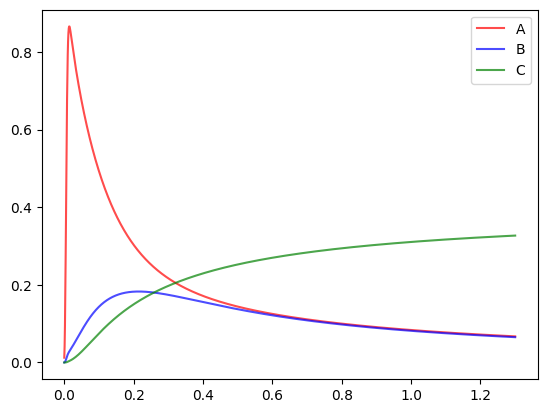

In [16]:
import matplotlib.pyplot as plt

colours = ['red', 'blue', 'green']

for i in range(3):
    plt.plot(times, timeSeries[compounds[i]], alpha = 0.7, color = colours[i], label = compounds[i])
plt.legend()

plt.savefig("results/mixed/timeSeries.png")

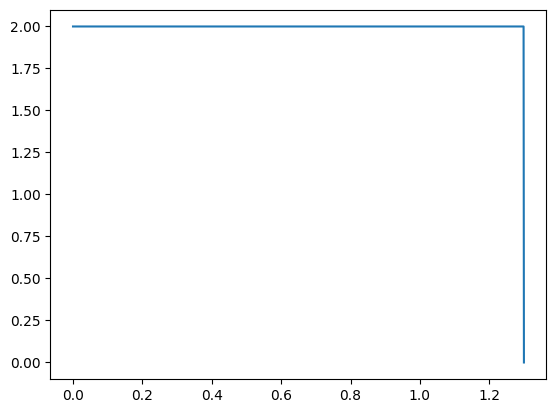

In [19]:
plt.plot(times, itterations)

In [51]:
# visualisation
pyvista.set_jupyter_backend('client')

pyvista.start_xvfb()

dist1, test = ZMixed.sub(2).collapse()

topologyZ, cell_typesZ, geometryZ = plot.vtk_mesh(dist1)
grid0 = pyvista.UnstructuredGrid(topologyZ, cell_typesZ, geometryZ)
grid0.point_data["s0"] = s_n.sub(1).collapse().x.array

grid1 = pyvista.UnstructuredGrid(topologyZ, cell_typesZ, geometryZ)
grid1.point_data["s1"] = s_.sub(1).collapse().x.array

topologyV, cell_typesV, geometryV = plot.vtk_mesh(V)
values = np.zeros((geometryV.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometryV.shape[0], len(u_n)))
velocity_grid = pyvista.UnstructuredGrid(topologyV, cell_typesV, geometryV)
velocity_grid["u"] = values
# Create a point cloud of glyphs
glyphs = velocity_grid.glyph(orient="u", factor=0.2)

plotter = pyvista.Plotter(notebook=True, shape=(1, 2))
plotter.subplot(0,0)
plotter.add_mesh(grid0, show_edges=True)
plotter.view_xy()
plotter.subplot (0,1)
plotter.add_mesh(grid1, show_edges=True)
plotter.view_xy()
#plotter.add_mesh(glyphs)

plotter.show()

Widget(value='<iframe src="http://localhost:40315/index.html?ui=P_0x7f38012f0b50_7&reconnect=auto" class="pyvi…

In [10]:
# f = fem.Constant(msh, PETSc.ScalarType(0))
# a = u * v * ufl.dx + dt * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
# L = (u_n + dt * f) * v * ufl.dx

In [84]:
solver.solve(s_)

(2, True)